# MVP: Data Science & Analytics - PUC-Rio
#### Autor: Rafael Hasslocher

#### Descrição

<small>Para esse MVP, utilizou-se uma base do Kaggle referente aos dados de poluição ao longo do tempo de um determinado conjunto de dados de treino (link: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate). Temos como objetivo prever os resultados do conjunto de teste fornecido no mesmo caminho.

O objetivo principal é realizar o ajuste com a base de treino e confrontar os resultados com a base de teste a partir de duas abordagens:

- Ajuste de um modelo ARIMA clássico;
- Ajuste de um modelo LSTM.

Ao final do trabalho, verificaremos a abordagem de melhor ajuste, contemplando as vantagens e desvantagens de suas aplicações.</small>


### Bloco 0 - Definição das funções úteis ao longo do projeto

In [1]:
import warnings
from itertools import product
from typing import TypedDict

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import LSTM, Dense, Dropout  # type: ignore
from keras.models import Sequential, load_model  # type: ignore
from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore
from tensorflow.keras.metrics import RootMeanSquaredError  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore


def plot_summary_serie(df, coluna_serie, coluna_tempo, periodicidade, summary):
    df = df.resample(periodicidade)[coluna_serie].apply(summary).reset_index()
    df.set_index(coluna_tempo, inplace=True)

    plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    grafico_summary = sns.lineplot(x=df.index, y=df[coluna_serie])

    summary_name = str(summary.__name__)

    grafico_summary.set_title(
        f"Sumarização considerando a função {summary_name} e periodicidade {periodicidade}"
    )

    plt.show()


def gera_boxplot(df, coluna_serie, index):
    boxplot = plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    ax = boxplot.add_subplot(111)

    plot = sns.boxplot(
        x=index,
        y=df[coluna_serie],
        ax=ax,
        hue=index,
        palette="GnBu",
        legend=False,
    )

    plot.set_title("Box-plot da poluição anual", fontsize=15)
    plot.set_xlabel("Ano", fontsize=10)
    plot.set_ylabel("Poluição", fontsize=10)  # noqa: E703
    plot.tick_params(axis="x", labelsize=8)
    plot.tick_params(axis="y", labelsize=8)

    plt.show()


def gera_acf_pacf(df, coluna_serie, lags, tipo):
    if tipo == "acf":
        acf_values = acf(df[coluna_serie], nlags=lags)
        plot_acf(df[coluna_serie], lags=lags)
        plt.title("Gráfico de Autocorrelação")
        plt.tick_params(labelsize=7)

        plt.ylim(bottom=min(0, min(acf_values)), top=max(acf_values))
    else:
        pacf_values = pacf(df[coluna_serie], nlags=lags)
        plot_pacf(df[coluna_serie], lags=lags)
        plt.title("Gráfico de Autocorrelação parcial")
        plt.tick_params(labelsize=7)

        plt.ylim(bottom=min(0, min(pacf_values)), top=max(pacf_values))

    plt.gcf().set_facecolor("whitesmoke")
    plt.show()


def count_warnings(warnings_list):
    tipos_warnings = {}
    for warn in warnings_list:
        tipo = type(warn.message).__name__
        if tipo in tipos_warnings:
            tipos_warnings[tipo] += 1
        else:
            tipos_warnings[tipo] = 1
    return tipos_warnings


class ModeloAjustado(TypedDict):
    model: ARIMA
    warnings: dict[str, int]


def ajustar_arima(time_series: pd.DataFrame, p: int, d: int, q: int) -> ModeloAjustado:
    with warnings.catch_warnings(record=True) as warns:
        model = ARIMA(time_series, order=(p, d, q))
        model_fit = model.fit()
    tipos_warnings = count_warnings(warns)
    return ModeloAjustado(model=model_fit, warnings=tipos_warnings)


class MetricasModelo(TypedDict):
    # pep8: nomes de variaveis são snake case (lower com underline separando)
    AIC: float
    BIC: float
    RMSE: float


def obter_metricas_modelo(modelo, time_series):
    predictions = modelo.predict(start=time_series.index[0], end=time_series.index[-1])
    rmse = root_mean_squared_error(time_series, predictions)
    return MetricasModelo(RMSE=rmse, AIC=modelo.aic, BIC=modelo.bic)


def cross_validate_arimas(p_values, d_values, q_values, time_series, split):
    resultados_resumido = {}
    params = {}

    # Considerar fazer isso fora da funcao e receber direto os params.
    for p, d, q in product(p_values, d_values, q_values):
        params[f"ARIMA({p=}, {d=}, {q=})"] = {"p": p, "d": d, "q": q}

    for name, param in params.items():
        resultados_modelo = []
        for train_index, test_index in split.split(time_series):
            train, test = time_series.iloc[train_index], time_series.iloc[test_index]

            try:
                ajuste_atual = ajustar_arima(train, param["p"], param["d"], param["q"])
            except Exception as e:
                print(
                    f"Erro ao ajustar o modelo ARIMA(p={param['p']}, d={param['d']}, {param['q']}): {e}"
                )
                continue
            metricas_atual = obter_metricas_modelo(ajuste_atual["model"], test)

            resultados_modelo.append(metricas_atual)
        tamanho = len(resultados_modelo)
        resultados_resumido[name] = {
            "p": param["p"],
            "d": param["d"],
            "q": param["q"],
            "AIC": sum([metricas["AIC"] for metricas in resultados_modelo]) / tamanho,
            "BIC": sum([metricas["BIC"] for metricas in resultados_modelo]) / tamanho,
            "RMSE": sum([metricas["RMSE"] for metricas in resultados_modelo]) / tamanho,
        }

    resultados_resumido = pd.DataFrame.from_dict(resultados_resumido, orient="index")

    print(f"O modelo de menor AIC médio é o {resultados_resumido['AIC'].idxmin()}.")
    print(f"O modelo de menor BIC médio é o {resultados_resumido['BIC'].idxmin()}.")
    print(f"O modelo de menor RMSE é o {resultados_resumido['RMSE'].idxmin()}.")

    return resultados_resumido


def gera_graficos_predict(time_series, p, d, q):
    modelo = ajustar_arima(time_series, p, d, q)
    yhat = modelo["model"].predict(
        start=time_series.index[0], end=time_series.index[-1]
    )
    plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    grafico_yhat = sns.lineplot(x=time_series.index, y=time_series, label="Real")
    sns.lineplot(x=time_series.index, y=yhat, color="red", label="Previsto")
    grafico_yhat.set_title(f"Gráfico para ARIMA({p}, {d}, {q})")
    grafico_yhat.set_xlabel("Eixo X")
    grafico_yhat.set_ylabel("Eixo Y")

    return yhat


def gera_ljungbox(time_series, p, d, q):
    ajuste = ajustar_arima(time_series, p, d, q)
    model = ajuste["model"]

    ljungbox = model.test_serial_correlation(method="ljungbox")

    print(f"\nResultados do teste de Ljung-Box para ARIMA({p}, {d}, {q}):\n")

    for lag in range(len(ljungbox[0][0])):
        p_valor = ljungbox[0][1][lag]
        print(f"Lag {lag + 1}: p-valor = {p_valor}")


def gera_diagnosticos(time_series, p, d, q):
    ajuste = ajustar_arima(time_series, p, d, q)
    model = ajuste["model"]

    tela_diagnostics = plt.figure(figsize=(10, 8), facecolor="whitesmoke")

    model.plot_diagnostics(fig=tela_diagnostics, auto_ylims=True)

    tela_diagnostics.suptitle(f"Gráficos de diagnóstico para ARIMA({p=}, {d=}, {q=})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


def construir_modelos_LSTM(hp, y_treino):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units_1", min_value=32, max_value=64, step=32),
            return_sequences=True,
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int("units_2", min_value=16, max_value=32, step=16),
            return_sequences=False,
        )
    )

    model.add(Dense(y_treino.shape[1]))
    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=0.001),
        metrics=[RootMeanSquaredError()],
    )
    return model

def arrays_LSTM(n_past, df, n_future):
    X = []
    y = []
    for i in range(n_past, len(df) - n_future + 1):
        X.append(df[i - n_past : i, 1 : df.shape[1]])
        y.append(df[i + n_future - 1 : i + n_future, 0])
    X, y = np.array(X), np.array(y)
    return X, y

### Bloco 1 - Leitura dos Dados

In [2]:
pd.options.display.float_format = "{:,.2f}".format

#input de dados de treino e de teste

base_treino = pd.read_csv("data/LSTM-Multivariate_pollution.csv")

base_teste = pd.read_csv("data/pollution_test_data1.csv")

#definição das variáveis utilizadas para o ajuste do ARIMA

coluna_serie = "pollution"
coluna_tempo = "date"

#definição da periodicidade da série. nesse caso, definimos a própria periodicidade do conjunto de treino (horária)

frequencia_serie = "h"

#aplicando transformações necessárias na base de treino

base_treino[coluna_tempo] = pd.to_datetime(base_treino[coluna_tempo])
base_treino.set_index(coluna_tempo, inplace=True)
base_treino = base_treino.asfreq(frequencia_serie)

base_treino.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,"43,800.00","43,800.00","43,800.00","43,800.00","43,800.00","43,800.00","43,800.00"
mean,94.01,1.83,12.46,"1,016.45",23.89,0.05,0.20
std,92.25,14.43,12.19,10.27,50.02,0.76,1.42
min,0.00,-40.00,-19.00,991.00,0.45,0.00,0.00
25%,24.00,-10.00,2.00,"1,008.00",1.79,0.00,0.00
50%,68.00,2.00,14.00,"1,016.00",5.37,0.00,0.00
75%,132.25,15.00,23.00,"1,025.00",21.91,0.00,0.00
max,994.00,28.00,42.00,"1,046.00",585.60,27.00,36.00


### Bloco 2 - Plotagem dos gráficos da série em uma periodicidade menos granular, para melhor visualização.

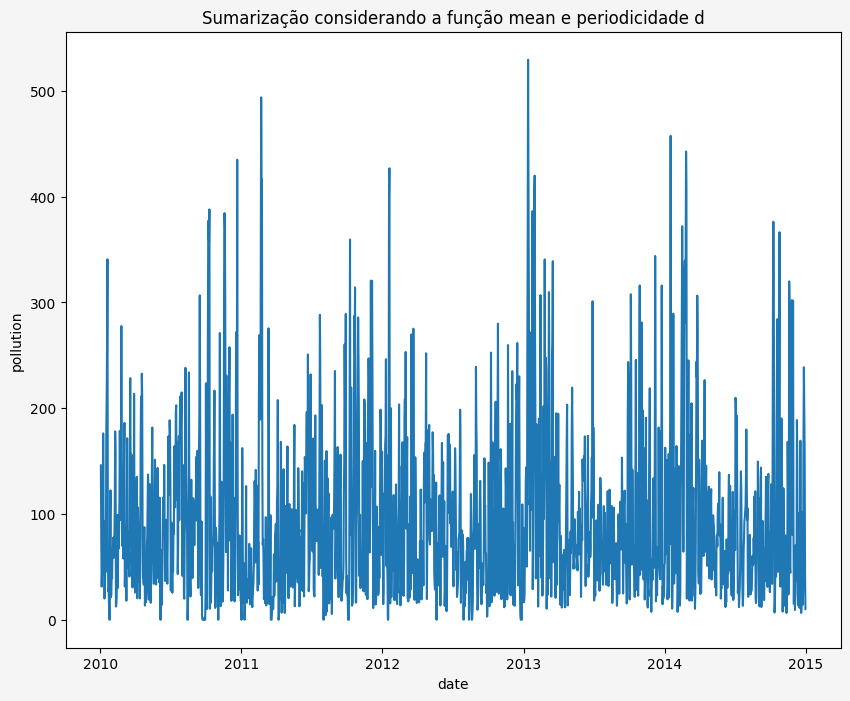

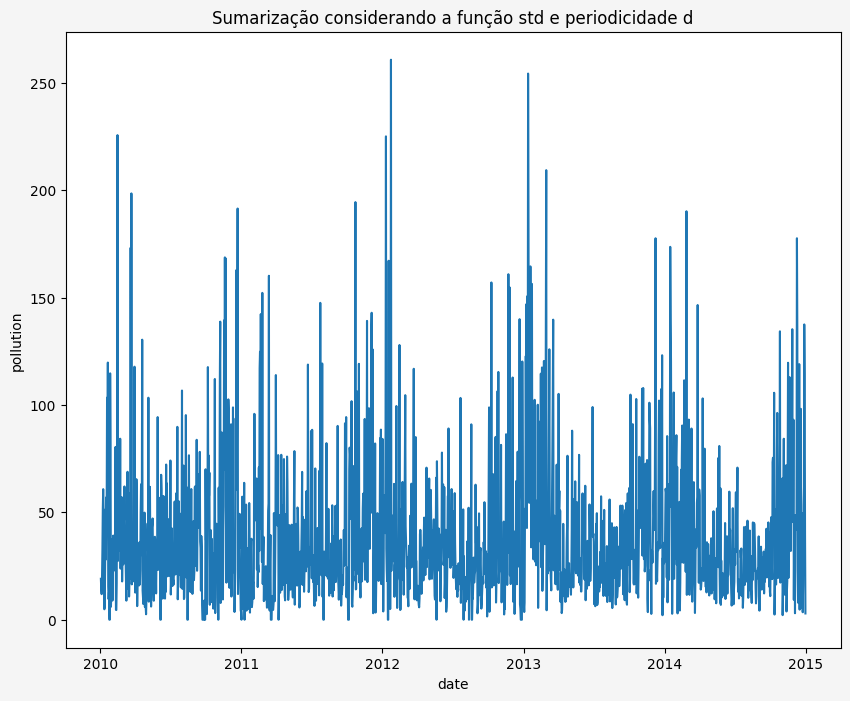

In [3]:
plot_summary_serie(base_treino, coluna_serie, coluna_tempo, periodicidade="d", summary=np.mean)
plot_summary_serie(base_treino, coluna_serie, coluna_tempo, periodicidade="d", summary=np.std)

Conforme pode ser verificado acima, a série parece ter um padrão bem estabelecido de variações periódicas ao longo dos anos tanto para a média quanto para o desvio-padrão.

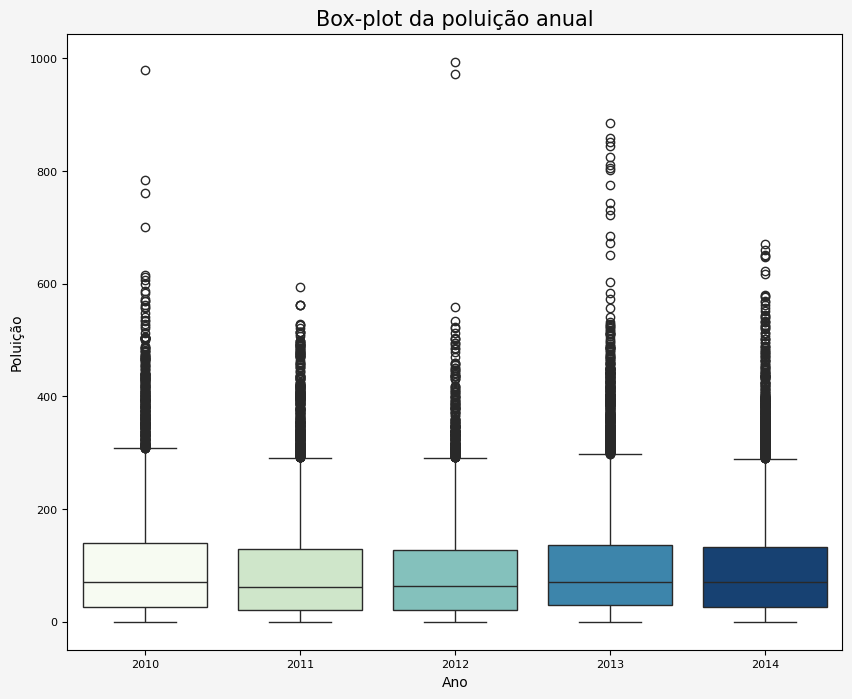

In [4]:
gera_boxplot(base_treino, coluna_serie, base_treino.index.year)

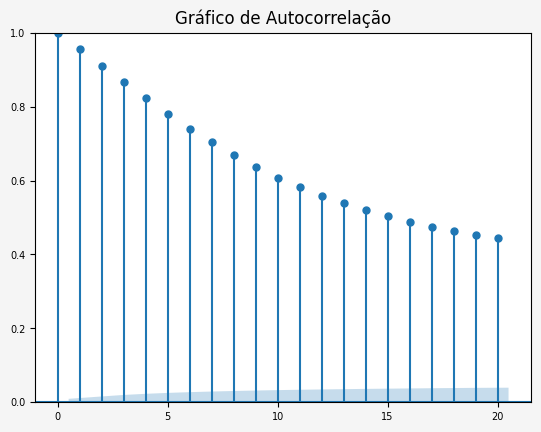

In [7]:
gera_acf_pacf(base_treino, coluna_serie, lags=20, tipo="acf")

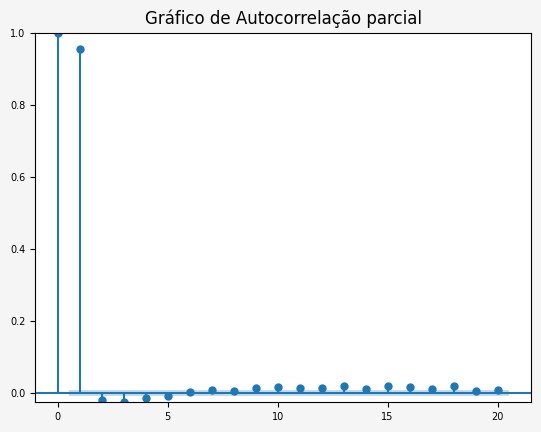

In [8]:
gera_acf_pacf(base_treino, coluna_serie, lags=20, tipo="pacf")

In [9]:
p_values = [1, 2, 3]
q_values = [1, 2, 3]
d_values = [0]

split = TimeSeriesSplit(n_splits=2)

resultados_cv = cross_validate_arimas(p_values, d_values, q_values, base_treino[coluna_serie], split)


O modelo de menor AIC médio é o ARIMA(p=2, d=0, q=2).
O modelo de menor BIC médio é o ARIMA(p=1, d=0, q=2).
O modelo de menor RMSE é o ARIMA(p=1, d=0, q=1).


In [10]:
result = adfuller(base_treino[coluna_serie])
print("Estatística ADF", result[0])
print("p-valor", result[1])

Estatística ADF -21.004108528409155
p-valor 0.0


In [11]:
p = 1
d = 0
q = 1

selecionado = ajustar_arima(base_treino[coluna_serie], p, d, q)

print(selecionado.get("warnings"))

{}


date
2010-01-02 00:00:00    94.01
2010-01-02 01:00:00   127.44
2010-01-02 02:00:00   145.91
2010-01-02 03:00:00   156.25
2010-01-02 04:00:00   177.46
                       ...  
2014-12-31 19:00:00    13.84
2014-12-31 20:00:00    11.88
2014-12-31 21:00:00    13.86
2014-12-31 22:00:00    13.82
2014-12-31 23:00:00    11.88
Freq: h, Name: predicted_mean, Length: 43800, dtype: float64

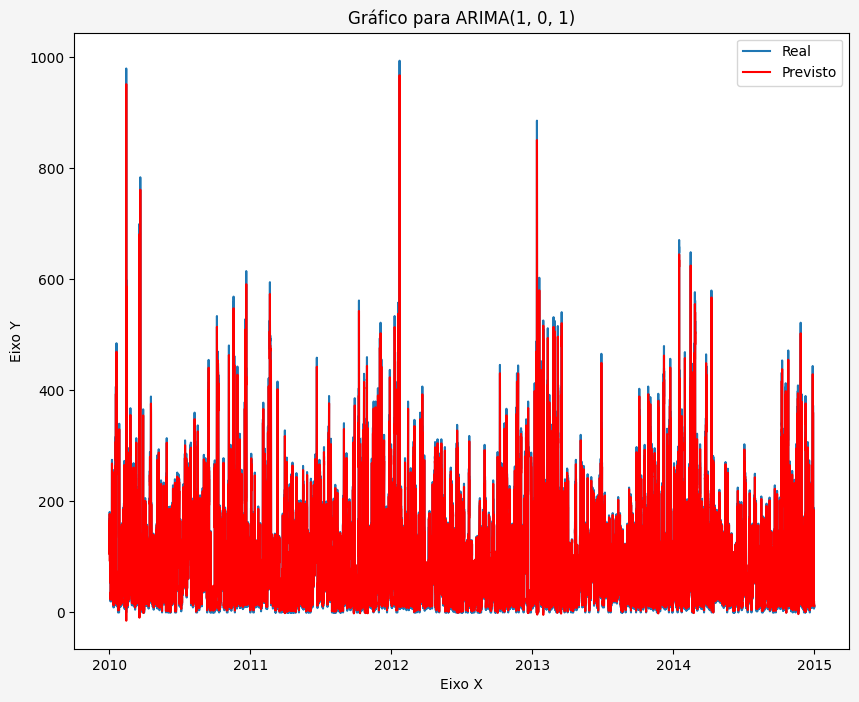

In [12]:
gera_graficos_predict(base_treino[coluna_serie], p, d, q)

In [13]:
gera_ljungbox(base_treino[coluna_serie], p, d, q)


Resultados do teste de Ljung-Box para ARIMA(1, 0, 1):

Lag 1: p-valor = 0.9133425219670078
Lag 2: p-valor = 1.90779338394746e-06
Lag 3: p-valor = 5.795734685437943e-07
Lag 4: p-valor = 1.48022205675698e-06
Lag 5: p-valor = 1.8462365536697876e-06
Lag 6: p-valor = 4.690585530959467e-07
Lag 7: p-valor = 3.4363798332306113e-07
Lag 8: p-valor = 6.239678157895268e-09
Lag 9: p-valor = 2.0902110978083792e-11
Lag 10: p-valor = 2.301571994650082e-12


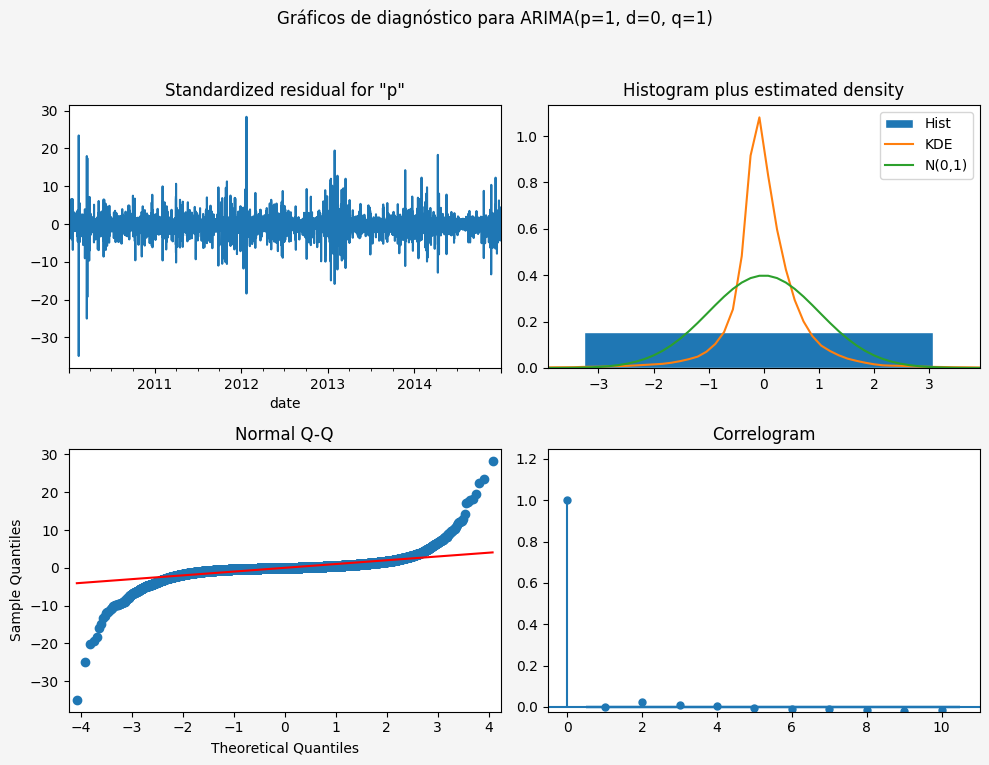

In [14]:
gera_diagnosticos(base_treino[coluna_serie], p, d, q)

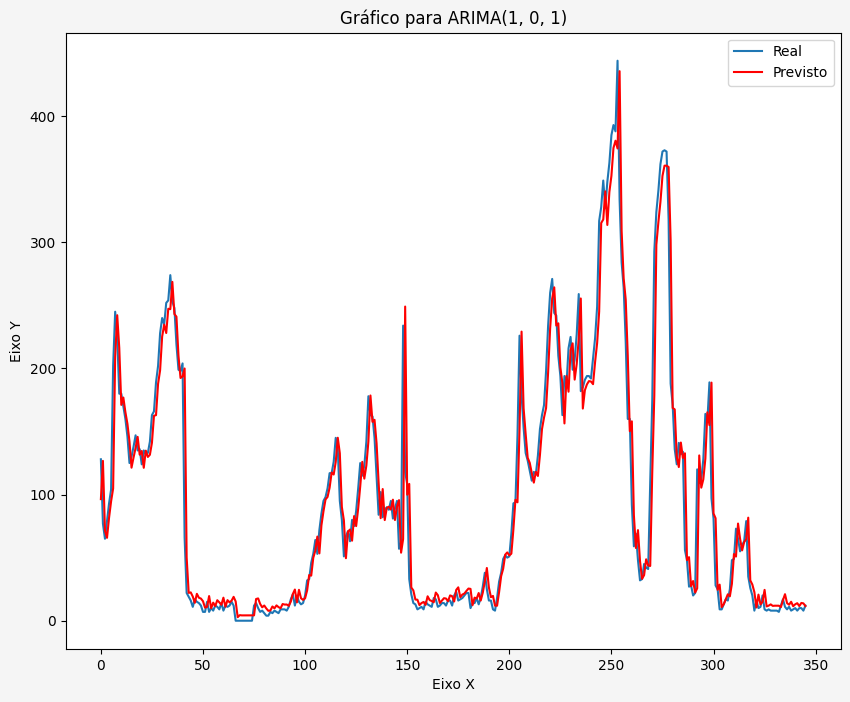

In [15]:
yhat = gera_graficos_predict(base_teste[coluna_serie], p, d, q)

In [16]:
base_treino_encoded = base_treino.copy()
base_teste_encoded = base_teste.copy()

# Define the mapping dictionary
mapping = {"NE": 0, "SE": 1, "NW": 2, "cv": 3}

# Replace the string values with numerical values
base_treino_encoded["wnd_dir"] = base_treino_encoded["wnd_dir"].map(mapping)
base_teste_encoded["wnd_dir"] = base_teste_encoded["wnd_dir"].map(mapping)

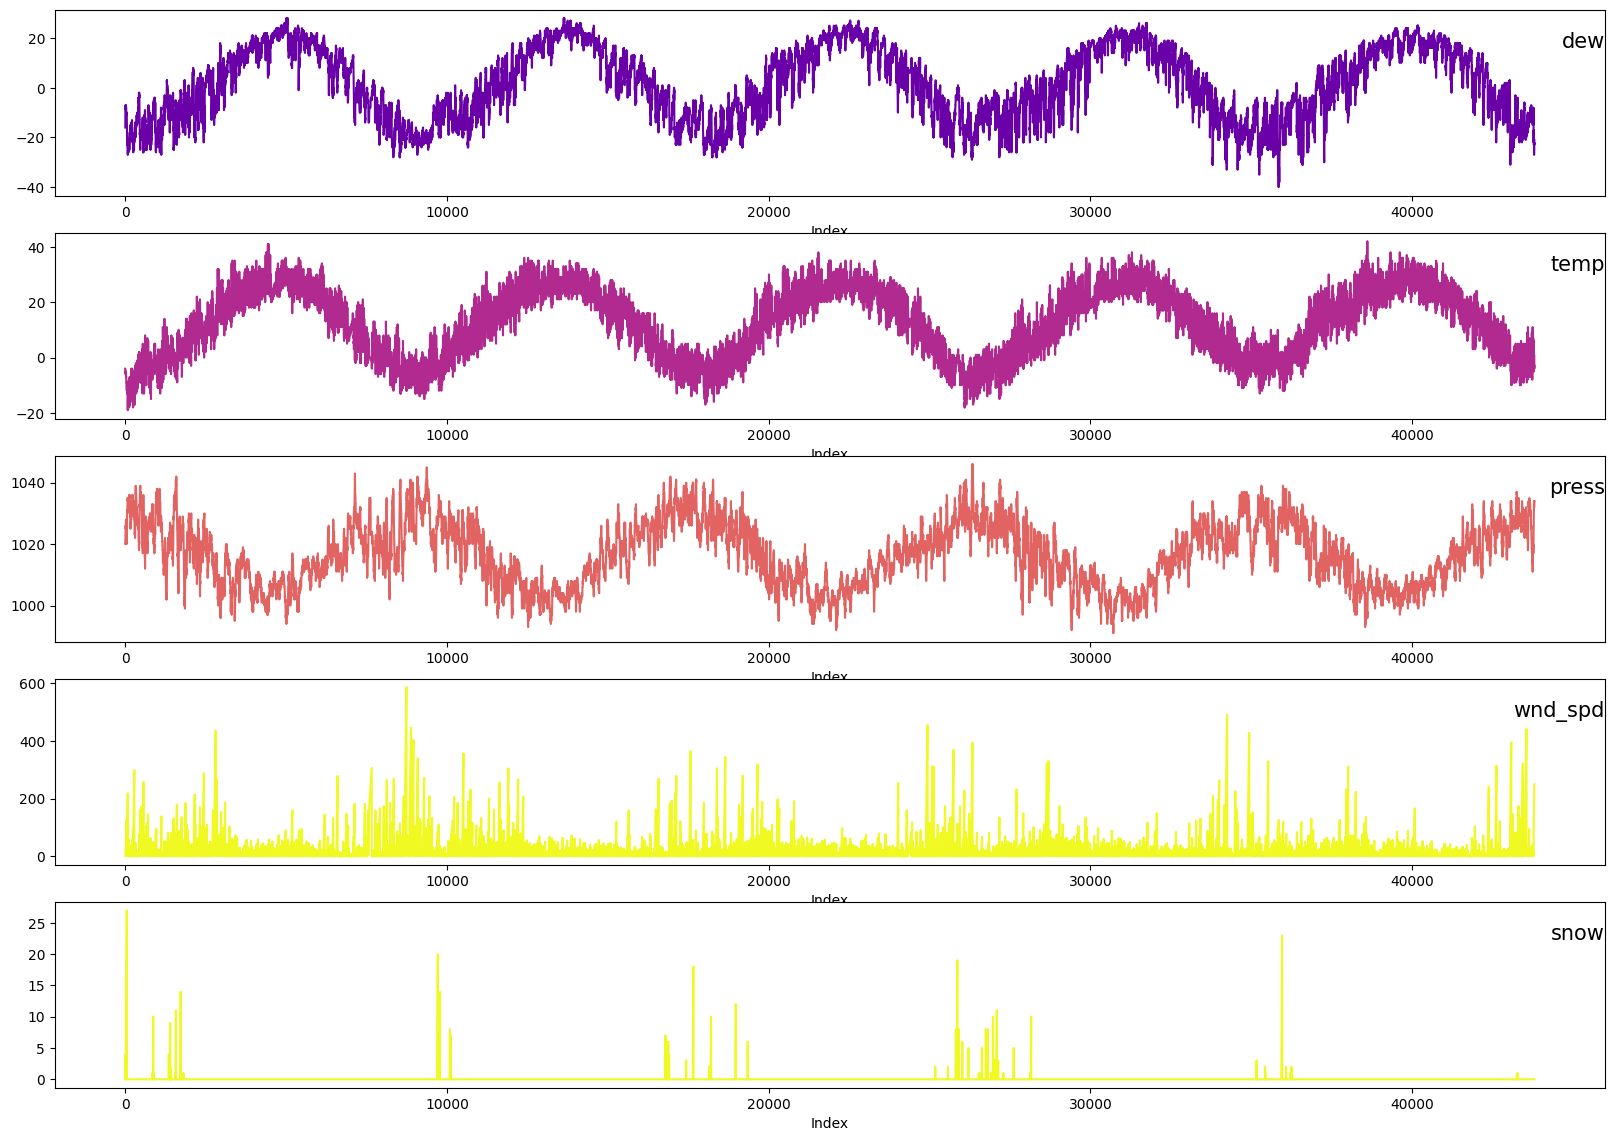

In [4]:
values = base_treino.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group / len(groups)))
    plt.xlabel("Index")
    plt.title(base_treino.columns[group], y=0.75, loc="right", fontsize=15)
    i += 1
plt.show()

sns.set_theme(style="darkgrid")

In [17]:
scaler = MinMaxScaler()

# Define the columns to scale
columns = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"]


base_treino_encoded = base_treino_encoded[columns]
base_teste_encoded = base_teste_encoded[columns]

# Scale the selected columns to the range 0-1
base_treino_encoded[columns] = scaler.fit_transform(base_treino_encoded[columns])
base_teste_encoded[columns] = scaler.transform(base_teste_encoded[columns])

# Show the scaled data
base_treino_encoded.head()

base_teste_encoded.head()

base_treino_encoded = np.array(base_treino_encoded)
base_teste_encoded = np.array(base_teste_encoded)

X_treino, y_treino = arrays_LSTM(n_past=11, df=base_treino_encoded, n_future=1)

X_teste, y_teste = arrays_LSTM(n_past=11, df=base_teste_encoded, n_future=1)


In [6]:
print(
    "X_train shape : {}   y_train shape : {} \n"
    "X_test shape : {}      y_test shape : {} ".format(
        X_treino.shape, y_treino.shape, X_teste.shape, y_teste.shape
    )
)

X_train shape : (43789, 11, 7)   y_train shape : (43789, 1) 
X_test shape : (43789, 11, 7)      y_test shape : (43789, 1) 


In [7]:
# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

tuner = RandomSearch(
    lambda hp: construir_modelos_LSTM(hp, y_treino),
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    directory="my_dir",
    project_name="lstm_tuning",
    overwrite=True,
)

tuner.search(
    X_treino,
    y_treino,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False,
)

Trial 3 Complete [00h 00m 33s]
val_loss: 0.01159474067389965

Best val_loss So Far: 0.009946873411536217
Total elapsed time: 00h 01m 52s


In [9]:
# Obter os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters()[0]

# Visualizar os valores dos melhores hiperparâmetros
print(f"Melhor número de unidades na primeira camada LSTM: {best_hps.get('units_1')}")
print(f"Melhor taxa de dropout na primeira camada: {best_hps.get('dropout_1')}")
print(f"Melhor número de unidades na segunda camada LSTM: {best_hps.get('units_2')}")

model = construir_modelos_LSTM(best_hps, y_treino)
history = model.fit(
    X_treino,
    y_treino,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False,
)


Melhor número de unidades na primeira camada LSTM: 64
Melhor taxa de dropout na primeira camada: 0.1
Melhor número de unidades na segunda camada LSTM: 32
Epoch 1/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 2/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 3/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 4/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 5/100
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 6/100
1232/1232 ━━━━━━━━━━━━━━━━━━

In [10]:
best_model = load_model("best_model.keras")

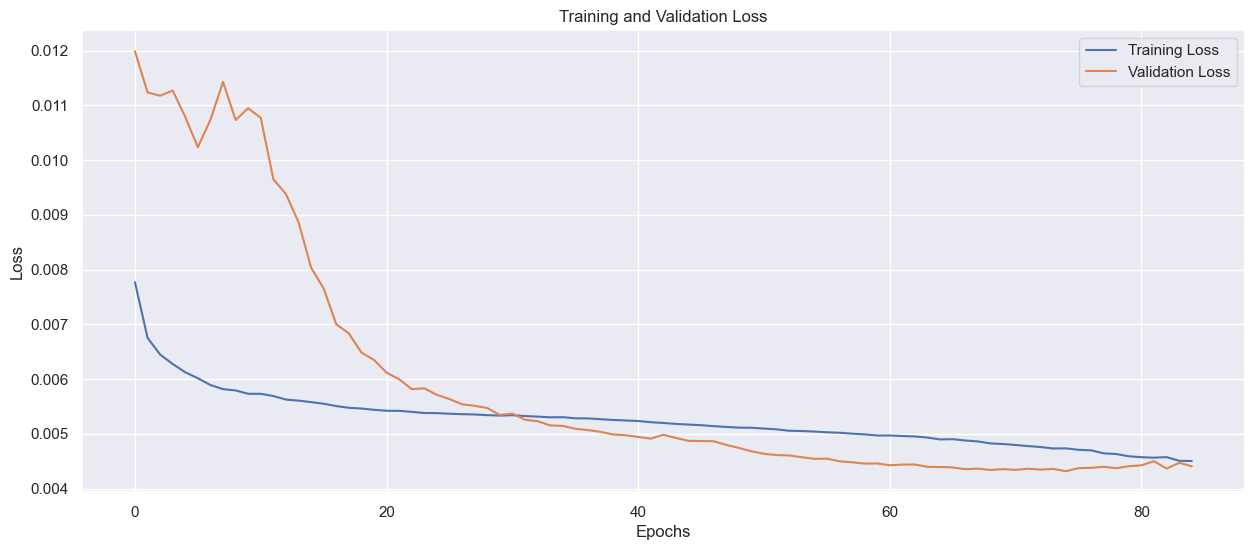

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


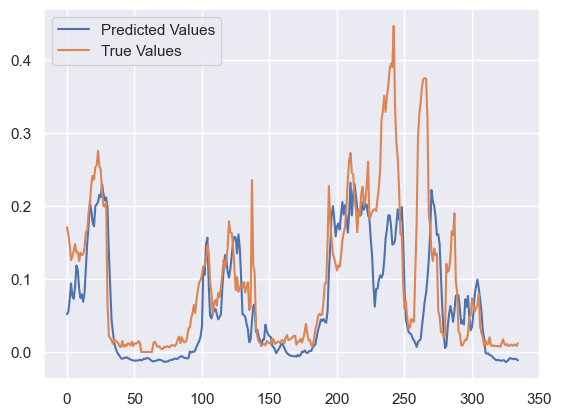

In [18]:

plt.figure(figsize=(15, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_predictions = best_model.predict(X_teste).flatten()
test_results = pd.DataFrame(
    data={"Train Predictions": test_predictions, "Actual": y_teste.flatten()}
)
test_results.head()

plt.plot(test_results["Train Predictions"], label="Predicted Values")
plt.plot(test_results["Actual"], label="True Values")
plt.legend()
plt.show()